[View in Colaboratory](https://colab.research.google.com/github/DigantaD/AIMLOS/blob/master/An_Unconventional_NER.ipynb)

In [0]:
import numpy as np
import warnings
import random
import re
import os.path
from os import path
import pickle
import math
import json

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [0]:
train_data = 'text.json'
with open(train_data) as file:
  data = json.load(file)

In [0]:
train_data = data['sentence_data']['examples']

In [4]:
data_list = []
seq_present = 0
for element in train_data:
  list1 = dict()
  query = element['text'].lower()
  length = len(element['slots'])
  seq_present += length
  for e in element['slots']:
    chunk = query[e['start']:e['end']]
    list1[chunk] = e['slot']
    list1[chunk] = e['slot']
  if len(element['slots']) == 0:
    list1[query] = ''
  data_list.append(list1)
print(data_list)
print(seq_present)

[{'adam': 'name'}, {'joey': 'name', 'sedan': 'car_type'}, {'germany': 'country', 'bmw': 'company'}, {'that place': 'place', 'australia': 'country'}, {'my friend': 'person', 'michael': 'name', 'canada': 'country'}, {'porsche': 'company', 'sedan': 'car_type'}, {'lexus': 'company', 'hatchback': 'car_type', '$80000': 'amount'}, {'have to pay': 'payment', '$500': 'amount', 'renew': 'renewal', 'car policy': 'document_type'}]
19


In [5]:
entities = []
for element in data_list:
  for key, value in element.items():
    if value not in entities and value != '':
      entities.append(value)
entities.sort()
print(entities)
print(len(entities))

['amount', 'car_type', 'company', 'country', 'document_type', 'name', 'payment', 'person', 'place', 'renewal']
10


In [6]:
ents = np.asarray(entities)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(ents)
onehot_encoder = OneHotEncoder(sparse = False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_entities = onehot_encoder.fit_transform(integer_encoded)
print(onehot_entities.shape)

(10, 10)


In [7]:
print(onehot_entities)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [0]:
embeddings_index = dict()
f = open('glove.6B.50d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray((values[1:]), np.float32)
  embeddings_index[word] = coefs
f.close()

In [0]:
from keras.preprocessing.text import Tokenizer

In [71]:
queries = []
for element in train_data:
  queries.append(element['text'].lower())
print(queries)

['my name is adam', 'joey has a sedan', 'germany is the home to the bmw', 'that place looks from australia', 'my friend, michael, is from canada', 'boy, that porsche sedan was sexy', 'my lexus hatchback cost me $80000', 'i have to pay $500 to renew my car policy']


In [72]:
print(len(queries))

8


In [0]:
t = Tokenizer(filters='!"#%&()*+,-.:;<=>?@[\]^`{|}~ ')
t.fit_on_texts(queries)

In [74]:
print(t.word_index)

{'my': 1, 'is': 2, 'to': 3, 'sedan': 4, 'the': 5, 'that': 6, 'from': 7, 'name': 8, 'adam': 9, 'joey': 10, 'has': 11, 'a': 12, 'germany': 13, 'home': 14, 'bmw': 15, 'place': 16, 'looks': 17, 'australia': 18, 'friend': 19, 'michael': 20, 'canada': 21, 'boy': 22, 'porsche': 23, 'was': 24, 'sexy': 25, 'lexus': 26, 'hatchback': 27, 'cost': 28, 'me': 29, '$80000': 30, 'i': 31, 'have': 32, 'pay': 33, '$500': 34, 'renew': 35, 'car': 36, 'policy': 37}


In [75]:
unk_words = []
for word, i in t.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is None:
    unk_words.append(word)
print(unk_words)
print(len(unk_words))

['porsche', 'lexus', 'hatchback', '$80000', '$500']
5


In [0]:
vectors_list = []
for key, value in embeddings_index.items():
  vectors_list.append(value)

In [0]:
vec1 = random.choice(vectors_list)
vec2 = random.choice(vectors_list)
unk_vec_for_word = (vec1+vec2)/2
vec1 = random.choice(vectors_list)
vec2 = random.choice(vectors_list)
unk_vec_for_amt = (vec1+vec2)/2

In [78]:
print(unk_vec_for_word)
print(unk_vec_for_amt)

[-4.5194501e-01  7.9995000e-01 -2.0574950e-01 -1.5642501e-01
 -1.8500090e-03  2.3838300e-01 -8.5426497e-01 -1.3631499e-01
 -2.3295999e-01 -4.3684989e-03 -4.0013000e-01  1.9265500e-01
 -1.6394988e-02 -7.7428997e-01  5.1502502e-01 -1.4045501e-01
  1.1516596e-01  2.9964998e-02 -3.4797502e-01 -8.6462498e-01
 -4.6662498e-01 -2.4211502e-01  5.5962503e-01 -6.3867497e-01
 -3.1372449e-01 -2.5013000e-01 -2.8203499e-01  5.3333497e-01
  3.7050000e-01 -8.0403996e-01  6.9684500e-01 -5.1800013e-03
 -1.8918000e-01  3.2656500e-01  3.0230400e-01 -8.1804998e-02
  9.1792502e-02 -2.2070195e-01  2.3339799e-01 -2.0835550e-01
 -6.0840003e-02  7.3000789e-04 -6.3412499e-01 -3.2438445e-01
  7.0880002e-01 -1.9609000e-01 -8.0717996e-02 -8.5014498e-01
 -8.7860000e-01  4.3355018e-02]
[-0.148455    1.28745     0.53170997  1.089295    0.489015    0.30116248
  0.645435    0.41838998 -0.84297    -0.4064979  -0.008109    0.194085
 -0.337665    0.15369     0.90692997 -0.30155498 -0.44323498 -0.526705
  0.2661955  -0.09361

In [0]:
final_data = []
for i in range(len(queries)):
  data_dict = dict()
  query = []
  query.append(queries[i])
  tw = Tokenizer(filters='!"#%&()*+,-.:;<=>?@[\]^`{|}~ ')
  tw.fit_on_texts(query)
  wordlist = []
  for word, j in tw.word_index.items():
    wordlist.append(word)
  ents = data_list[i]
  data_dict['query'] = queries[i]
  sequences = []
  for word in wordlist:
    index = wordlist.index(word)
    seq = ''
    for w in wordlist[index:]:
      seq = seq + w
      sequences.append(seq)
      seq = seq + ' '
  data_dict['sequences'] = sequences
  final_data.append(data_dict)

In [80]:
print(final_data)

[{'query': 'my name is adam', 'sequences': ['my', 'my name', 'my name is', 'my name is adam', 'name', 'name is', 'name is adam', 'is', 'is adam', 'adam']}, {'query': 'joey has a sedan', 'sequences': ['joey', 'joey has', 'joey has a', 'joey has a sedan', 'has', 'has a', 'has a sedan', 'a', 'a sedan', 'sedan']}, {'query': 'germany is the home to the bmw', 'sequences': ['the', 'the germany', 'the germany is', 'the germany is home', 'the germany is home to', 'the germany is home to bmw', 'germany', 'germany is', 'germany is home', 'germany is home to', 'germany is home to bmw', 'is', 'is home', 'is home to', 'is home to bmw', 'home', 'home to', 'home to bmw', 'to', 'to bmw', 'bmw']}, {'query': 'that place looks from australia', 'sequences': ['that', 'that place', 'that place looks', 'that place looks from', 'that place looks from australia', 'place', 'place looks', 'place looks from', 'place looks from australia', 'looks', 'looks from', 'looks from australia', 'from', 'from australia', 'au

In [81]:
number_of_seq = 0
for element in final_data:
    number_of_seq = number_of_seq + len(element['sequences'])
print(number_of_seq)

164


In [0]:
def get_X(i , sequence, chunk):
  
  chunk_mean = np.zeros((1, 50))
  
  if chunk is not None:
    token = Tokenizer(filters='!"#%&()*+,-.:;<=>?@[\]^`{|}~ ')
    token.fit_on_texts(chunk)
    wordlist = []
    for word, j in token.word_index.items():
      wordlist.append(word)
    embeddings_matrix = np.zeros((len(wordlist), 50))
    counter = 0
    for word in wordlist:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is None:
        if word.isdigit():
          embedding_vector = unk_vec_for_num
        elif word[0] == '$' or word[len(word)-1] == '$':
          embedding_vector = unk_vec_for_amt
        else:
          embedding_vector = unk_vec_for_word
      embeddings_matrix[counter] = embedding_vector
      counter += 1
    
    for x in range(len(wordlist)):
      if x == 0:
        sum_arr = embeddings_matrix[x]
      else:
        sum_arr = np.sum((sum_arr, embeddings_matrix[x]), axis = 0)
    
    chunk_mean = sum_arr/len(wordlist)
    
  seq_mean = np.zeros((1, 50))
  
  token = Tokenizer(filters='!"#%&()*+,-.:;<=>?@[\]^`{|}~ ')
  token.fit_on_texts(sequence)
  wordlist = []
  for word, j in token.word_index.items():
    wordlist.append(word)
  embeddings_matrix = np.zeros((len(wordlist), 50))
  counter = 0
  for word in wordlist:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
      if word.isdigit():
        embedding_vector = unk_vec_for_num
      elif word[0] == '$' or word[len(word)-1] == '$':
        embedding_vector = unk_vec_for_amt
      else:
        embedding_vector = unk_vec_for_word
    embeddings_matrix[counter] = embedding_vector
    counter += 1
      
  for x in range(len(wordlist)):
    if x==0:
      sum_arr = embeddings_matrix[x]
    else:
      sum_arr = np.sum((sum_arr, embeddings_matrix[x]), axis = 0)
        
  seq_mean = sum_arr/len(wordlist)
  
  mean = (chunk_mean+seq_mean)/2
  
  mean = mean.reshape(1, 50)
  
  return mean

In [0]:
X_train = np.zeros((number_of_seq*len(entities), 50 + len(entities)))
Y_train = []
i = 0
for j in range(len(queries)):
  query = []
  query.append(queries[j])
  tw = Tokenizer(filters='!"#%&()*+,-.:;<=>?@[\]^`{|}~ ')
  tw.fit_on_texts(query)
  wordlist = []
  for word, k in tw.word_index.items():
    wordlist.append(word)
  seq = final_data[j]
  for sequence in seq['sequences']:
    wl = sequence.split(' ')
    index = wordlist.index(wl[0])
    chunk = ''
    for word in wordlist[:index]:
      chunk = chunk + word
      chunk = chunk + ' '
    if chunk == '':
      index = wordlist.index(wl[len(wl)-1])
      chunk = ''
      for word in wordlist[index+1:]:
        chunk = chunk + word
        chunk = chunk + ' '
    slots = data_list[j]
    slot = ''
    for key in slots:
      if sequence == key:
        slot = slots[sequence]
        break
    if chunk == '':
      chunk = None
    mean = get_X(i, sequence, chunk)
    
    mean = mean.reshape(50, 1)
    
    rows = onehot_entities.shape[0]
    for x in range(rows):
      oh = onehot_entities[x].reshape(len(entities), 1)
      conc = np.concatenate((mean, oh))
      conc = conc.reshape(1, 50 + len(entities))
      X_train[i] = conc
      inverted = label_encoder.inverse_transform([np.argmax(onehot_entities[x, :])])
      warnings.simplefilter('ignore')
      inverted = inverted.tolist()
      if inverted[0] == slot:
        Y_train.append(1.)
      else:
        Y_train.append(0.)
      i += 1  

In [0]:
Y_train = np.asarray(Y_train)

In [85]:
print(X_train.shape)
print(Y_train.shape)

(1640, 60)
(1640,)


In [86]:
print(X_train)

[[-0.07214607  1.13712573  0.65815783 ...  0.          0.
   0.        ]
 [-0.07214607  1.13712573  0.65815783 ...  0.          0.
   0.        ]
 [-0.07214607  1.13712573  0.65815783 ...  0.          0.
   0.        ]
 ...
 [-0.13996437  0.90470696  0.57222086 ...  1.          0.
   0.        ]
 [-0.13996437  0.90470696  0.57222086 ...  0.          1.
   0.        ]
 [-0.13996437  0.90470696  0.57222086 ...  0.          0.
   1.        ]]


In [87]:
print(Y_train)

[0. 0. 0. ... 0. 0. 0.]


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_tr, X_te, Y_tr, Y_te = train_test_split(X_train, Y_train, test_size = 0.1, shuffle = True, random_state = 1)

In [154]:
print(X_tr.shape, X_te.shape)

(1476, 60) (164, 60)


In [0]:
X_tr = X_tr.reshape(X_tr.shape[0], 1, 50+len(entities))
Y_tr = Y_tr.reshape(Y_tr.shape[0], 1, 1)
X_te = X_te.reshape(X_te.shape[0], 1, 50+len(entities))
Y_te = Y_te.reshape(Y_te.shape[0], 1, 1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [0]:
model = Sequential()
model.add(Bidirectional(LSTM(8, return_sequences = True), input_shape = (1, 50 + len(entities))))
model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))

In [0]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [159]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 1, 16)             4416      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 1)              17        
Total params: 4,433
Trainable params: 4,433
Non-trainable params: 0
_________________________________________________________________


In [0]:
es = EarlyStopping(monitor  ='loss', patience = 1, verbose = 1, mode = 'auto')

In [161]:
model.fit(X_tr, Y_tr, batch_size = 4, epochs = 10, verbose = 1, callbacks = [es])

Epoch 1/10
1476/1476 [==============================] - 3s 2ms/step - loss: 0.1418 - acc: 0.9858
Epoch 2/10
1476/1476 [==============================] - 1s 855us/step - loss: 0.0622 - acc: 0.9892
Epoch 3/10
1476/1476 [==============================] - 1s 865us/step - loss: 0.0615 - acc: 0.9892
Epoch 4/10
1476/1476 [==============================] - 1s 922us/step - loss: 0.0609 - acc: 0.9892
Epoch 5/10
1476/1476 [==============================] - 1s 865us/step - loss: 0.0602 - acc: 0.9892
Epoch 6/10
1476/1476 [==============================] - 1s 865us/step - loss: 0.0597 - acc: 0.9892
Epoch 7/10
1476/1476 [==============================] - 1s 867us/step - loss: 0.0591 - acc: 0.9892
Epoch 8/10
1476/1476 [==============================] - 1s 890us/step - loss: 0.0588 - acc: 0.9892
Epoch 9/10
1476/1476 [==============================] - 1s 873us/step - loss: 0.0583 - acc: 0.9892
Epoch 10/10
1476/1476 [==============================] - 1s 925us/step - loss: 0.0579 - acc: 0.9892


In [162]:
scores = model.evaluate(X_tr, Y_tr, verbose = 1)

1476/1476 [==============================] - 1s 385us/step


In [163]:
print("Train accuracy %s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

Train accuracy acc: 98.92%


In [164]:
scores = model.evaluate(X_te, Y_te, verbose = 1)

164/164 [==============================] - 0s 86us/step


In [165]:
print("Test accuracy %s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

Test accuracy acc: 98.78%


In [0]:
y_pred = model.predict_proba(X_te)

In [0]:
Y_te = Y_te.reshape(Y_te.shape[0], 1)
y_pred = y_pred.reshape(y_pred.shape[0], 1)

In [168]:
print(Y_te)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [169]:
y_pred

array([[0.01065764],
       [0.00705858],
       [0.0034373 ],
       [0.00835782],
       [0.01184279],
       [0.0032508 ],
       [0.00919849],
       [0.00896665],
       [0.00763249],
       [0.01207199],
       [0.00973587],
       [0.011722  ],
       [0.00424213],
       [0.00861724],
       [0.00858412],
       [0.00361395],
       [0.00338492],
       [0.00424125],
       [0.00773545],
       [0.00649827],
       [0.00368109],
       [0.00918062],
       [0.00953237],
       [0.00412304],
       [0.00805803],
       [0.0070406 ],
       [0.00307523],
       [0.00897101],
       [0.01055859],
       [0.00721806],
       [0.00465675],
       [0.01317654],
       [0.00431777],
       [0.00329427],
       [0.00924229],
       [0.01166465],
       [0.00724677],
       [0.0100687 ],
       [0.00972375],
       [0.0122925 ],
       [0.00395773],
       [0.00347822],
       [0.00691085],
       [0.00812327],
       [0.0087219 ],
       [0.01142838],
       [0.00812414],
       [0.013

In [0]:
predicted = y_pred[:,0]

In [171]:
print(predicted)

[0.01065764 0.00705858 0.0034373  0.00835782 0.01184279 0.0032508
 0.00919849 0.00896665 0.00763249 0.01207199 0.00973587 0.011722
 0.00424213 0.00861724 0.00858412 0.00361395 0.00338492 0.00424125
 0.00773545 0.00649827 0.00368109 0.00918062 0.00953237 0.00412304
 0.00805803 0.0070406  0.00307523 0.00897101 0.01055859 0.00721806
 0.00465675 0.01317654 0.00431777 0.00329427 0.00924229 0.01166465
 0.00724677 0.0100687  0.00972375 0.0122925  0.00395773 0.00347822
 0.00691085 0.00812327 0.0087219  0.01142838 0.00812414 0.01338669
 0.00924811 0.00750213 0.00548583 0.02535952 0.00896733 0.01216664
 0.00817216 0.00622227 0.00597152 0.00731198 0.00905507 0.00788989
 0.01149281 0.01254796 0.01580211 0.00922212 0.00442928 0.00819164
 0.01174114 0.00853518 0.0121953  0.00545902 0.00694017 0.00974283
 0.00584452 0.00672682 0.00692675 0.01777343 0.0120385  0.00733928
 0.01136962 0.0035028  0.00821388 0.00950449 0.01016648 0.01092514
 0.00397007 0.00967733 0.00742042 0.01173705 0.00851113 0.0076324

In [0]:
from sklearn.metrics import roc_curve, auc

In [0]:
fpr, tpr, thresholds = roc_curve(Y_te, predicted)

In [174]:
print(fpr, tpr, thresholds)

[0.         0.00617284 0.31481481 0.31481481 0.58024691 0.59259259
 0.66666667 0.67901235 0.85802469 0.86419753 0.90123457 0.91358025
 0.96296296 0.97530864 1.        ] [0.  0.  0.  0.5 0.5 0.5 0.5 0.5 0.5 1.  1.  1.  1.  1.  1. ] [1.0253595  0.02535952 0.00972375 0.00967733 0.00768583 0.00763249
 0.0070406  0.00694017 0.00412304 0.00397007 0.00371991 0.00368109
 0.00329427 0.0032508  0.00283273]


In [175]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.412037037037037


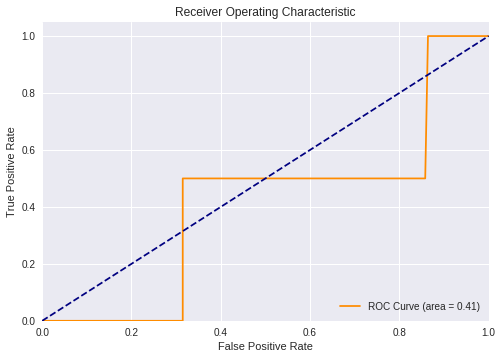

In [176]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color = 'darkorange',label = 'ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()

<Container object of 15 artists>

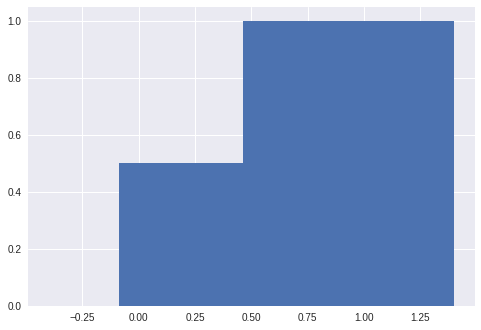

In [177]:
plt.bar(fpr, tpr)

In [178]:
test_query = "India is a great country"
test_queries = [test_query]
test_queries

['India is a great country']

In [179]:
test_data = []
for i in range(len(test_queries)):
  data_dict = dict()
  query = []
  query.append(test_queries[i])
  tw = Tokenizer(filters='!"#%&()*+,-.:;<=>?@[\]^`{|}~ ')
  tw.fit_on_texts(query)
  wordlist = []
  for word, j in tw.word_index.items():
    wordlist.append(word)
  ents = data_list[i]
  data_dict['query'] = test_queries[i]
  sequences = []
  for word in wordlist:
    index = wordlist.index(word)
    seq = ''
    for w in wordlist[index:]:
      seq = seq + w
      sequences.append(seq)
      seq = seq + ' '
  data_dict['sequences'] = sequences
  test_data.append(data_dict)
print(test_data)

[{'query': 'India is a great country', 'sequences': ['india', 'india is', 'india is a', 'india is a great', 'india is a great country', 'is', 'is a', 'is a great', 'is a great country', 'a', 'a great', 'a great country', 'great', 'great country', 'country']}]


In [181]:
number_of_seq = 0
for element in test_data:
    number_of_seq = number_of_seq + len(element['sequences'])
print(number_of_seq)

15


In [0]:
X_example = np.zeros((number_of_seq*len(entities), 50 + len(entities)))
i = 0
for j in range(len(test_queries)):
  query = []
  query.append(test_queries[j])
  tw = Tokenizer(filters='!"#%&()*+,-.:;<=>?@[\]^`{|}~ ')
  tw.fit_on_texts(query)
  wordlist = []
  for word, k in tw.word_index.items():
    wordlist.append(word)
  seq = test_data[j]
  for sequence in seq['sequences']:
    wl = sequence.split(' ')
    index = wordlist.index(wl[0])
    chunk = ''
    for word in wordlist[:index]:
      chunk = chunk + word
      chunk = chunk + ' '
    if chunk == '':
      index = wordlist.index(wl[len(wl)-1])
      chunk = ''
      for word in wordlist[index+1:]:
        chunk = chunk + word
        chunk = chunk + ' '
    if chunk == '':
      chunk = None
    slots = data_list[j]
    slot = ''
    for key in slots:
      if sequence == key:
        slot = slots[sequence]
        break
    if slot == '':
      slot = None
    mean = get_X(i, sequence, chunk)
    
    mean = mean.reshape(50, 1)
    
    rows = onehot_entities.shape[0]
    for x in range(rows):
      oh = onehot_entities[x].reshape(len(entities), 1)
      conc = np.concatenate((mean, oh))
      conc = conc.reshape(1, 50 + len(entities))
      X_example[i] = conc
      i += 1  

In [183]:
print(X_example)

[[-0.03193463  0.71398959  0.4153172  ...  0.          0.
   0.        ]
 [-0.03193463  0.71398959  0.4153172  ...  0.          0.
   0.        ]
 [-0.03193463  0.71398959  0.4153172  ...  0.          0.
   0.        ]
 ...
 [-0.14983793  0.81940635  0.63753812 ...  1.          0.
   0.        ]
 [-0.14983793  0.81940635  0.63753812 ...  0.          1.
   0.        ]
 [-0.14983793  0.81940635  0.63753812 ...  0.          0.
   1.        ]]


In [184]:
X_example.shape

(150, 60)

In [0]:
X_example = X_example.reshape(X_example.shape[0], 1, 50 + len(entities))

In [0]:
result = model.predict(X_example)

In [0]:
result = result.reshape(result.shape[0], 1)

In [0]:
result = result.tolist()

In [189]:
print(result)

[[0.008454184979200363], [0.011567942798137665], [0.011537466198205948], [0.012191835790872574], [0.008629487827420235], [0.012026033364236355], [0.004046418704092503], [0.004016896244138479], [0.008449733257293701], [0.008900457061827183], [0.008811017498373985], [0.012064527720212936], [0.012030894868075848], [0.012602875009179115], [0.00897796731442213], [0.012407567352056503], [0.004099156241863966], [0.004088650457561016], [0.008748249150812626], [0.009187614545226097], [0.008811017498373985], [0.012064527720212936], [0.012030894868075848], [0.012602875009179115], [0.00897796731442213], [0.012407567352056503], [0.004099156241863966], [0.004088650457561016], [0.008748249150812626], [0.009187614545226097], [0.008079543709754944], [0.01103593222796917], [0.011077403090894222], [0.011530693620443344], [0.008331695571541786], [0.011524466797709465], [0.003802521387115121], [0.003830457804724574], [0.008115614764392376], [0.008540445938706398], [0.017346737906336784], [0.024592285975813

In [0]:
def divide_chunks(l, n):
  for i in range(0, len(l), n):
    yield l[i:i + n]

In [191]:
for element in result:
  index = result.index(element)
  result[index] = element[0]
print(result)

[0.008454184979200363, 0.011567942798137665, 0.011537466198205948, 0.012191835790872574, 0.008629487827420235, 0.012026033364236355, 0.004046418704092503, 0.004016896244138479, 0.008449733257293701, 0.008900457061827183, 0.008811017498373985, 0.012064527720212936, 0.012030894868075848, 0.012602875009179115, 0.00897796731442213, 0.012407567352056503, 0.004099156241863966, 0.004088650457561016, 0.008748249150812626, 0.009187614545226097, 0.008811017498373985, 0.012064527720212936, 0.012030894868075848, 0.012602875009179115, 0.00897796731442213, 0.012407567352056503, 0.004099156241863966, 0.004088650457561016, 0.008748249150812626, 0.009187614545226097, 0.008079543709754944, 0.01103593222796917, 0.011077403090894222, 0.011530693620443344, 0.008331695571541786, 0.011524466797709465, 0.003802521387115121, 0.003830457804724574, 0.008115614764392376, 0.008540445938706398, 0.017346737906336784, 0.024592285975813866, 0.023388026282191277, 0.02558807283639908, 0.017315374687314034, 0.02438117936

In [192]:
result_list = list(divide_chunks(result, len(entities)))
print(result_list)

[[0.008454184979200363, 0.011567942798137665, 0.011537466198205948, 0.012191835790872574, 0.008629487827420235, 0.012026033364236355, 0.004046418704092503, 0.004016896244138479, 0.008449733257293701, 0.008900457061827183], [0.008811017498373985, 0.012064527720212936, 0.012030894868075848, 0.012602875009179115, 0.00897796731442213, 0.012407567352056503, 0.004099156241863966, 0.004088650457561016, 0.008748249150812626, 0.009187614545226097], [0.008811017498373985, 0.012064527720212936, 0.012030894868075848, 0.012602875009179115, 0.00897796731442213, 0.012407567352056503, 0.004099156241863966, 0.004088650457561016, 0.008748249150812626, 0.009187614545226097], [0.008079543709754944, 0.01103593222796917, 0.011077403090894222, 0.011530693620443344, 0.008331695571541786, 0.011524466797709465, 0.003802521387115121, 0.003830457804724574, 0.008115614764392376, 0.008540445938706398], [0.017346737906336784, 0.024592285975813866, 0.023388026282191277, 0.02558807283639908, 0.017315374687314034, 0.02

In [193]:
sequences = test_data[0]['sequences']
print(sequences)

['india', 'india is', 'india is a', 'india is a great', 'india is a great country', 'is', 'is a', 'is a great', 'is a great country', 'a', 'a great', 'a great country', 'great', 'great country', 'country']


In [194]:
for i in range(len(sequences)):
  prob_list = result_list[i]
  ranked = sorted(prob_list, reverse = True)
  rank_dict = dict()
  for e in ranked:
    index = prob_list.index(e)
    rank_dict[entities[index]] = e
  print("Sequence: ", sequences[i])
  print("Rank: ", rank_dict)
  print('\n')

Sequence:  india
Rank:  {'country': 0.012191835790872574, 'name': 0.012026033364236355, 'car_type': 0.011567942798137665, 'company': 0.011537466198205948, 'renewal': 0.008900457061827183, 'document_type': 0.008629487827420235, 'amount': 0.008454184979200363, 'place': 0.008449733257293701, 'payment': 0.004046418704092503, 'person': 0.004016896244138479}


Sequence:  india is
Rank:  {'country': 0.012602875009179115, 'name': 0.012407567352056503, 'car_type': 0.012064527720212936, 'company': 0.012030894868075848, 'renewal': 0.009187614545226097, 'document_type': 0.00897796731442213, 'amount': 0.008811017498373985, 'place': 0.008748249150812626, 'payment': 0.004099156241863966, 'person': 0.004088650457561016}


Sequence:  india is a
Rank:  {'country': 0.012602875009179115, 'name': 0.012407567352056503, 'car_type': 0.012064527720212936, 'company': 0.012030894868075848, 'renewal': 0.009187614545226097, 'document_type': 0.00897796731442213, 'amount': 0.008811017498373985, 'place': 0.0087482491